In [2]:
%pip install opencv-python

import cv2
import os

# Define paths for video folders and output
input_paths = {"Violence": "RLVS/Violence", "NonViolence": "RLVS/NonViolence"}
output_dir = "RLVS_frames"

# Create output directories for frames
os.makedirs(output_dir, exist_ok=True)
os.makedirs(f"{output_dir}/Violence", exist_ok=True)
os.makedirs(f"{output_dir}/NonViolence", exist_ok=True)

def extract_frames(video_path, output_folder, interval=30):
    """Extract frames from video at a given interval."""
    cap = cv2.VideoCapture(video_path)
    count = 0
    video_name = os.path.basename(video_path).split('.')[0]

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Save every 'interval' frame
        if count % interval == 0:
            frame_path = os.path.join(output_folder, f"{video_name}_frame{count}.jpg")
            cv2.imwrite(frame_path, frame)
        count += 1
    cap.release()

# Process each video
for label, folder_path in input_paths.items():
    for video_file in os.listdir(folder_path):
        video_path = os.path.join(folder_path, video_file)
        output_folder = f"{output_dir}/{label}"
        extract_frames(video_path, output_folder)


Note: you may need to restart the kernel to use updated packages.


[h264 @ 0xaaf7140] mb_type 104 in P slice too large at 98 31
[h264 @ 0xaaf7140] error while decoding MB 98 31


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
dataset_path = "RLVS_frames"
violence_path = os.path.join(dataset_path, "Violence")
nonviolence_path = os.path.join(dataset_path, "NonViolence")

# Create train and test directories
train_dir = "RLVS_split/train"
test_dir = "RLVS_split/test"
os.makedirs(os.path.join(train_dir, "Violence"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "NonViolence"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "Violence"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "NonViolence"), exist_ok=True)

# Helper function to split and move files
def split_and_move_files(src_folder, dest_train, dest_test):
    files = os.listdir(src_folder)
    train_files, test_files = train_test_split(files, test_size=0.3, random_state=42)
    for file in train_files:
        shutil.move(os.path.join(src_folder, file), dest_train)
    for file in test_files:
        shutil.move(os.path.join(src_folder, file), dest_test)

# Split the datasets
split_and_move_files(violence_path, os.path.join(train_dir, "Violence"), os.path.join(test_dir, "Violence"))
split_and_move_files(nonviolence_path, os.path.join(train_dir, "NonViolence"), os.path.join(test_dir, "NonViolence"))


In [4]:
%pip install tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image data generators
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Prepare train and test data
train_data = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=64, class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=64, class_mode='categorical')


Note: you may need to restart the kernel to use updated packages.


2025-01-25 02:24:47.848638: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-25 02:24:47.937194: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-25 02:24:48.009182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737752088.060400   39517 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737752088.082777   39517 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 02:24:48.230249: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Found 7315 images belonging to 2 classes.
Found 3136 images belonging to 2 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0

# Load pre-trained EfficientNetB0
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


W0000 00:00:1737752113.108394   39517 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
# Train the model
history = model.fit(train_data, validation_data=test_data, epochs=20)

# Save the trained model
model.save("efficientnetb0_rlvs.h5")


/home/devansh/Desktop/Final-Year-Project/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2025-01-25 02:25:40.085335: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38535168 exceeds 10% of free system memory.
2025-01-25 02:25:40.147473: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38880000 exceeds 10% of free system memory.
2025-01-25 02:25:40.156298: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-01-25 02:25:40.222482: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-01-25 02:25:40.256698: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


115/115 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.5166 - loss: 0.7092 - val_accuracy: 0.5555 - val_loss: 0.6874
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.5425 - loss: 0.6916 - val_accuracy: 0.5555 - val_loss: 0.6898
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.5293 - loss: 0.6942 - val_accuracy: 0.5555 - val_loss: 0.6874
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.5544 - loss: 0.6878 - val_accuracy: 0.5555 - val_loss: 0.6875
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.5399 - loss: 0.6907 - val_accuracy: 0.5555 - val_loss: 0.6882
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.5541 - loss: 0.6894 - val_accuracy: 0.5555 - val_loss: 0.6903
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.5357 - loss: 0.6896 - val_accuracy: 0.5555 - val_loss: 0.6883
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.5670 - loss: 0.6874 - val_accuracy: 0.555

In [7]:
# Evaluate the model
results = model.evaluate(test_data)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5397 - loss: 0.6900
Test Loss: 0.6875618696212769, Test Accuracy: 0.5554847121238708


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 683ms/step


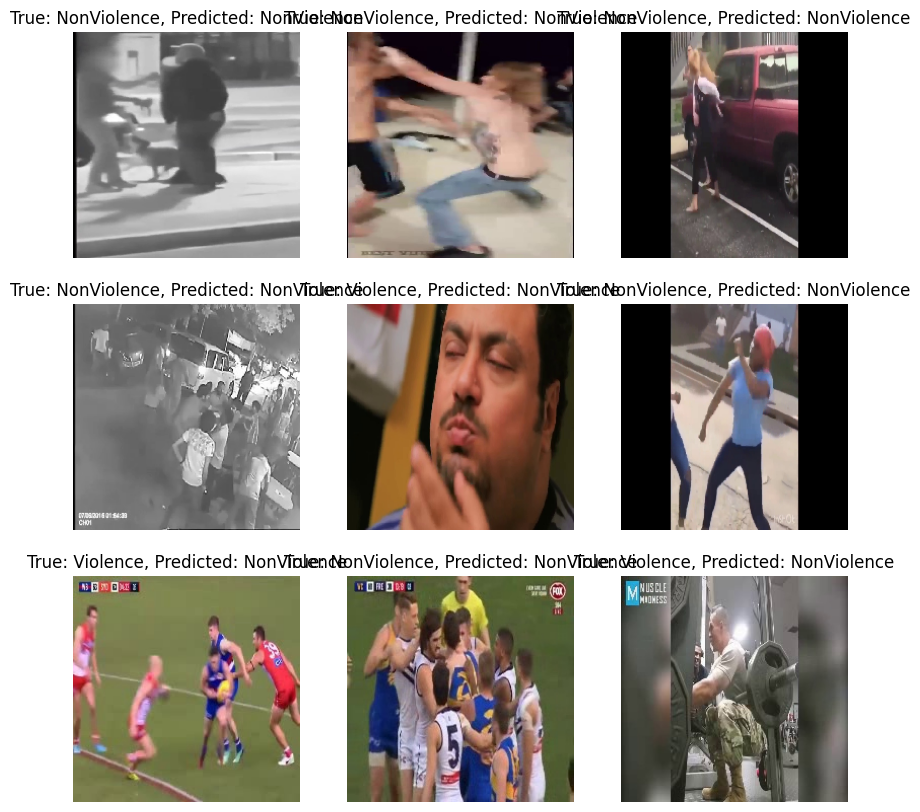

In [9]:
#write the code to visualize a few violent and non-violent frames from the test set
import matplotlib.pyplot as plt

# Get a batch of test data
test_images, test_labels = next(test_data)

# Make predictions
predictions = model.predict(test_images)

# Map label indices to class names
class_names = {0: 'Violence', 1: 'NonViolence'}

# Visualize the images with their predicted class
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    class_idx = tf.argmax(test_labels[i]).numpy()
    predicted_class_idx = tf.argmax(predictions[i]).numpy()
    true_label = class_names[class_idx]
    predicted_label = class_names[predicted_class_idx]
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis("off")
plt.show()


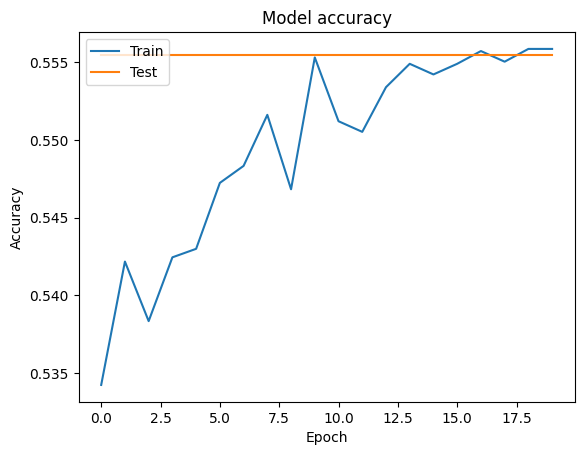

In [10]:
#write the code to visualize the training and validation loss and accuracy
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()